In [49]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import torch.utils.data as data_utils

torch.set_default_dtype(torch.float32)

## Load data

In [55]:
mods = [transforms.ToTensor(), 
        transforms.Normalize((0.1307,), (0.3081,)),    #mean and std of MNIST
        transforms.Lambda(lambda x: torch.flatten(x))]
mods = transforms.Compose(mods)

trainset = datasets.MNIST(root='./data/train', train=True, download=True, transform=mods)
testset = datasets.MNIST(root='./data/test', train=False, download=True, transform=mods)

#### Subset the training set

In [69]:
indices = torch.arange(100)
trainset = data_utils.Subset(trainset, indices)

In [70]:
batch_size = 64

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=1)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=1)

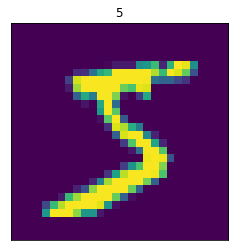

In [71]:
plt.imshow(trainset[0][0].reshape((28, 28)));
plt.title(trainset[0][1]);
plt.xticks([])
plt.yticks([]);

## Prepare a single network module

In [72]:
class SimpleNetwork(torch.nn.Module):
    def __init__(self, inp_size, layers=[100]):
        super().__init__()
        self.layers = []
        
        self.inp = torch.nn.Linear(inp_size, layers[0])
        self.output = torch.nn.Linear(layers[0], 10)
        self.relu = torch.nn.ReLU()
        self.softmax = torch.nn.Softmax()
    
    def forward(self, x):
        out = x
        out = self.inp(out)
        out = self.relu(out)
        out = self.output(out)
        return out

In [73]:
def train_net(net, optimizer, epochs, verbose=False):
    for epoch in range(epochs): 
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(trainloader):
            inputs, labels = data

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            correct += (outputs.argmax(1)==labels).float().sum()
            total += outputs.shape[0]
            running_loss += loss.item()
            if i % 100 == 0:    # print every 2000 mini-batches
                if verbose:
                    print('[%d, %5d] loss: %.3f acc: %.3f%%' %
                          (epoch + 1, i, running_loss / 100, correct/total*100))
                running_loss = 0.0
                correct = 0
                total=0

        correct = 0
        test_loss = 0
        for i, data in enumerate(testloader):
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            loss = criterion(outputs, labels)
            test_loss += loss.item()
        print(f"Test acc: {correct/len(testset)*100}, loss: {test_loss/i:.3f}")
        
    return correct/len(testset)*100, test_loss/i

### Benchmark

#### Full network

In [74]:
net = SimpleNetwork(784)

In [75]:
criterion = torch.nn.CrossEntropyLoss()

In [76]:
%%time
optimizer = torch.optim.Adam(net.parameters(), lr=3e-3)
train_net(net, optimizer, 5)
optimizer = torch.optim.Adam(net.parameters(), lr=3e-4)
final_loss = train_net(net, optimizer, 5)

Test acc: 48.949999999999996, loss: 1.884
Test acc: 53.92, loss: 1.531
Test acc: 62.08, loss: 1.233
Test acc: 65.71000000000001, loss: 1.073
Test acc: 66.39, loss: 1.037
Test acc: 67.06, loss: 1.014
Test acc: 66.97, loss: 1.013
Test acc: 67.32000000000001, loss: 1.006
Test acc: 67.66, loss: 1.000
Test acc: 67.88, loss: 0.996
CPU times: user 22.1 s, sys: 2.18 s, total: 24.2 s
Wall time: 18.3 s


#### Masked input (for further benchmark)

In [64]:
input_size = 784
mask_size = 700

np.random.seed(42)
template = np.zeros(input_size)
mask_idx = np.random.choice(len(template), mask_size, False)
template[mask_idx] = 1
mask = torch.from_numpy(template).to(torch.bool)

In [65]:
mask_idx

array([598, 590, 209, 637, 174, 213, 429, 259, 593, 204, 576, 244, 235,
       218, 770, 155, 516,  67, 579, 109,  66, 522,  78, 473,  23, 211,
       706, 445, 644,  39, 332,  86, 137, 653, 656, 442, 525, 515, 334,
       630, 342, 780, 118, 652, 260, 779, 352, 432,  77, 691, 483, 682,
        49, 518, 168, 326, 377, 375, 568, 309, 629,  30, 361,  33,  31,
       627, 558, 405, 254, 412, 739, 486, 266, 331, 422, 231, 333, 357,
       620, 265,  54, 735, 514,  97, 506, 294, 234, 749, 311, 351, 120,
       436,  84,  10, 624, 464, 192, 530, 199,  29, 470, 323,  65, 350,
       659, 239,  81, 485, 291, 487, 264, 715, 535, 519,  76, 388, 523,
       570,  72, 693, 409, 208, 585,  63, 314, 672, 302, 750, 363, 393,
       752, 367, 705,   7, 533, 101, 428, 765, 745,   2, 398, 527, 764,
       196, 641, 729, 493, 448, 215, 425, 581, 417,  79, 148, 335, 247,
       559, 762, 133, 648,  55, 411, 597, 675, 545, 617, 720, 296, 362,
        60, 741, 360, 440, 662, 426, 383, 327, 584, 286,  90, 38

In [68]:
class MaskedNetwork(SimpleNetwork):
    def __init__(self, input_size, mask_size, layers=[10]):
        super().__init__(mask_size, layers=layers)
        template = np.zeros(input_size)
        mask = np.random.choice(len(template), mask_size, False)
        template[mask] = 1
        self.mask = torch.from_numpy(template).to(torch.bool)
        
    def forward(self, x):
        data = x[:, self.mask]
        return super().forward(data)

masked_net = MaskedNetwork(784, 700)
masked_net.mask = mask
optimizer = torch.optim.Adam(masked_net.parameters(), lr=3e-4)
train_net(masked_net, optimizer, 20)

Test acc: 21.5, loss: 2.194
Test acc: 29.99, loss: 2.066
Test acc: 38.18, loss: 1.938
Test acc: 46.339999999999996, loss: 1.822
Test acc: 52.339999999999996, loss: 1.717
Test acc: 55.300000000000004, loss: 1.621
Test acc: 57.54, loss: 1.538
Test acc: 58.68, loss: 1.461
Test acc: 60.25, loss: 1.387
Test acc: 61.339999999999996, loss: 1.321
Test acc: 63.38, loss: 1.254
Test acc: 64.63, loss: 1.188
Test acc: 66.3, loss: 1.126
Test acc: 67.91, loss: 1.066
Test acc: 69.87, loss: 1.009
Test acc: 73.08, loss: 0.953
Test acc: 75.44999999999999, loss: 0.901
Test acc: 77.56, loss: 0.853
Test acc: 78.66, loss: 0.812
Test acc: 79.41, loss: 0.781


(79.41, 0.7807565442262552)

## Create simple network with insertable weights

In [8]:
flat_parameters = []
for layer in net.parameters():
    flat_parameters.extend(torch.flatten(layer).detach().numpy())
    
flat_parameters = torch.from_numpy(np.array(flat_parameters))

NameError: name 'net' is not defined

In [9]:
import torch.nn.functional as F

class InsertableNet(SimpleNetwork):
    def __init__(self, weights, inp_size, layers=[100]):
        super().__init__(inp_size, layers)
        input_w_size = inp_size*layers[0]
        input_b_size = layers[0]

        hidden_w_size = layers[0]*10
        hidden_b_size = 10

        self.inp_weights = weights[:input_w_size].reshape((layers[0], inp_size))
        self.inp_bias = weights[input_w_size:input_w_size+input_b_size]

        self.output_weights = weights[input_w_size+input_b_size:input_w_size+input_b_size+hidden_w_size].reshape((10, layers[0]))
        self.output_bias = weights[input_w_size+input_b_size+hidden_w_size:input_w_size+input_b_size+hidden_w_size+hidden_b_size]

#         self.inp.weight = self.inp_weights
#         self.inp.bias = torch.nn.Parameter(inp_bias, requires_grad=True)
#         self.output.weight = torch.nn.Parameter(output_weights, requires_grad=True)
#         self.output.bias = torch.nn.Parameter(output_bias, requires_grad=True)        
    
    def forward(self, data):
        # Yeah, this is hardly scalable so we need to find a way
        # to make the layer-wise approach work
        out = F.linear(data, self.inp_weights, self.inp_bias)
        out = self.relu(out)
        out = F.linear(out, self.output_weights, self.output_bias)
        return out

In [318]:
insert_net = InsertableNet(flat_parameters, 784)

In [319]:
correct = 0
for data in testloader:
    images, labels = data
    outputs = insert_net(images)
    _, predicted = torch.max(outputs.data, 1)
    correct += (predicted == labels).sum().item()
print(f"Test acc: {correct/len(testset)*100}")
assert correct/len(testset)*100 == final_loss

Test acc: 98.00999999999999


## Create hypernet structure

In [37]:
class Hypernetwork(torch.nn.Module):
    def __init__(self, inp_size=784, mask_size=20, node_hidden_size=20, layers=[64, 256, 128], test_nodes=100):
        super().__init__()
        self.device = "cuda"
        
        self.mask_size = mask_size
        self.input_size = inp_size
        self.node_hidden_size = node_hidden_size
        
        input_w_size = mask_size*node_hidden_size
        input_b_size = node_hidden_size

        hidden_w_size = node_hidden_size*10
        hidden_b_size = 10
            
        self.out_size = input_w_size+input_b_size+hidden_w_size+hidden_b_size
        
        self.input = torch.nn.Linear(inp_size, layers[0])
        self.hidden1 = torch.nn.Linear(layers[0], layers[1])
        self.hidden2 = torch.nn.Linear(layers[1], layers[2])
        self.out = torch.nn.Linear(layers[2], self.out_size)
        
        self.dropout = torch.nn.Dropout()
        
        self.relu = torch.nn.ReLU()
        self.template = np.zeros(inp_size)
        self.test_nodes = test_nodes
        self.test_mask = self._create_mask(test_nodes)
        
    def to(self, device):
        super().to(device)
        self.device = device
        self.test_mask = self._create_mask(self.test_nodes)
        return self
        
    def forward(self, data, mask=None):
        """ Get a hypernet prediction.
        
        Args:
            data - prediction input
            mask - either None or a torch.tensor((data.shape[0], data.shape[1])).
        """
        if self.training:
            if mask is None:
                masks = np.array([np.random.choice((len(self.template)), self.mask_size, False) for _ in range(len(data))])
                tmp = np.array([self.template.copy() for _ in range(len(data))])
                for i, mask in enumerate(masks):
                    tmp[i, mask] = 1
                mask = torch.from_numpy(tmp).to(torch.float32).to(self.device)

            weights = self.craft_network(mask)
            res = torch.zeros((len(data), 10)).to(self.device)
            for i in range(len(data)):
                nn = InsertableNet(weights[i], self.mask_size, layers=[self.node_hidden_size])
                masked_data = data[i, mask[i].to(torch.bool)]
                res[i] = nn(masked_data)
            return res
        else:
            if mask is None:
                mask = self.test_mask

            nets = []
            weights = self.craft_network(mask)
            res = torch.zeros((len(data), 10)).to(self.device)
            for i in range(len(mask)):
                nn = InsertableNet(weights[i], self.mask_size, layers=[self.node_hidden_size])
                masked_data = data[:, mask[i].to(torch.bool)]
                res += nn(masked_data)
            res /= self.test_nodes
            return res

#     def forward(self, data, mask=None):
#         if mask is None:
#             mask = np.random.choice(len(template), self.mask_size, False)
#             tmp = self.template.copy()
#             tmp[mask] = 1
#             mask = torch.from_numpy(tmp).to(torch.float32).cuda()
        
#         weights = self.craft_network(mask)
#         nn = InsertableNet(weights, self.mask_size, layers=[self.node_hidden_size])
#         masked_data = data[:, mask.to(torch.bool)]
#         return nn(masked_data)
        
    def _create_mask(self, count):
        masks = np.array([np.random.choice((len(self.template)), self.mask_size, False) for _ in range(count)])
        tmp = np.array([self.template.copy() for _ in range(count)])
        for i, mask in enumerate(masks):
            tmp[i, mask] = 1
        mask = torch.from_numpy(tmp).to(torch.float32).to(self.device)
        return mask
    
    def craft_network(self, mask):
        out = self.input(mask)
        out = self.relu(out)
        
        out = self.hidden1(out)
        out = self.relu(out)
        out = self.dropout(out)
        
        out = self.hidden2(out)
        out = self.relu(out)
        
        out = self.out(out)
        return out

In [38]:
from torchsummary import summary

In [39]:
hypernet = Hypernetwork(mask_size=700).to("cpu")

In [40]:
list(hypernet.parameters())[0]

Parameter containing:
tensor([[ 0.0350, -0.0182, -0.0311,  ...,  0.0310, -0.0154, -0.0165],
        [-0.0354, -0.0193,  0.0170,  ..., -0.0345, -0.0146, -0.0036],
        [-0.0022, -0.0332, -0.0063,  ...,  0.0164, -0.0190, -0.0211],
        ...,
        [-0.0208, -0.0089, -0.0350,  ...,  0.0016,  0.0251,  0.0167],
        [ 0.0287,  0.0052, -0.0297,  ..., -0.0199, -0.0157,  0.0129],
        [ 0.0058,  0.0261,  0.0068,  ..., -0.0041, -0.0128,  0.0054]],
       requires_grad=True)

In [42]:
summary(hypernet, (784, ), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]          50,240
              ReLU-2                   [-1, 64]               0
            Linear-3                  [-1, 256]          16,640
              ReLU-4                  [-1, 256]               0
           Dropout-5                  [-1, 256]               0
            Linear-6                  [-1, 128]          32,896
              ReLU-7                  [-1, 128]               0
            Linear-8                [-1, 14230]       1,835,670
Total params: 1,935,446
Trainable params: 1,935,446
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.12
Params size (MB): 7.38
Estimated Total Size (MB): 7.50
----------------------------------------------------------------


In [44]:
optimizer = torch.optim.Adam(hypernet.parameters(), lr=3e-4)
criterion = torch.nn.CrossEntropyLoss()
train_net(hypernet, optimizer, 1, verbose=True);

[1,     0] loss: 0.024 acc: 6.250%
[1,   100] loss: 1.563 acc: 46.000%
[1,   200] loss: 1.048 acc: 65.500%
[1,   300] loss: 0.935 acc: 70.969%
[1,   400] loss: 0.807 acc: 73.500%
[1,   500] loss: 0.791 acc: 74.750%
[1,   600] loss: 0.736 acc: 77.156%
[1,   700] loss: 0.691 acc: 77.875%
[1,   800] loss: 0.672 acc: 78.375%
[1,   900] loss: 0.655 acc: 79.766%
Test acc: 80.28999999999999, loss: 0.612


In [45]:
list(hypernet.parameters())[0]

Parameter containing:
tensor([[ 0.0333, -0.0187, -0.0325,  ...,  0.0298, -0.0179, -0.0195],
        [-0.0369, -0.0199,  0.0147,  ..., -0.0360, -0.0127, -0.0052],
        [-0.0044, -0.0355, -0.0087,  ...,  0.0138, -0.0216, -0.0236],
        ...,
        [-0.0238, -0.0125, -0.0366,  ..., -0.0007,  0.0218,  0.0157],
        [ 0.0255,  0.0044, -0.0318,  ..., -0.0210, -0.0200,  0.0110],
        [ 0.0025,  0.0214,  0.0057,  ..., -0.0071, -0.0153,  0.0022]],
       requires_grad=True)

## Conclusion
The network is able to train, so everything is working as expected. Now, we can focus on the raw score optimization.